<a href="https://colab.research.google.com/github/makkimaki/python-bayes-intro/blob/main/%E3%81%99%E3%82%89%E3%81%99%E3%82%89%E3%83%99%E3%82%A4%E3%82%BA%E5%86%99%E7%B5%8C_3%E2%88%922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ベイズ回帰モデル
「予測」、「分析」が回帰分析の目的。この分析と相性が良い。影響度の大きな説明変数を見つけ出す方法で活用できるのがベイズ回帰モデル。

### 問題設定
- データセット: LSL-DR (Listening and Spoken Language Data Repository)
- 音声言語の発達に影響を与える要因を調査するデータを収集している。
- pymc公式チュートリアルに似た分析例あり。hierarchical regularized horseshoe(おそらく、事前分布にstudent-t分布を用いて正則化している？）



In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.12

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.7.2'
sns.__version__='0.12.0'
np.__version__='1.23.5'


In [3]:
df = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)

df.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


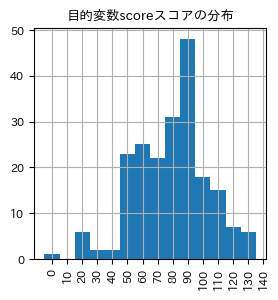

In [4]:
bins = np.arange(0, 150, 10)
fig, ax = plt.subplots()
df["score"].hist(bins=bins, align="left")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title("目的変数scoreスコアの分布")
plt.xticks(bins);
plt.show()

In [5]:
# display(df.describe())
# df["age_test_month"] = df["age_test"] / 12
print(df.isnull().sum())
display(df.describe())

score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64


,score,male,siblings,family_inv,prev_disab,age_test,non_severe_hl,mother_hs
count,207.000000,207.000000,207.000000,174.000000,189.000000,207.000000,207.000000,134.000000
mean,84.193237,0.512077,1.125604,0.977011,0.238095,53.545894,0.415459,0.701493
std,24.885590,0.501066,0.866682,1.002621,0.427049,3.631920,0.493996,0.459320
min,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000
25%,68.000000,0.000000,1.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,87.000000,1.000000,1.000000,1.000000,0.000000,54.000000,0.000000,1.000000
75%,98.000000,1.000000,2.000000,2.000000,0.000000,57.000000,1.000000,1.000000
max,144.000000,1.000000,3.000000,4.000000,1.000000,59.000000,1.000000,1.000000


In [6]:
df1 = df.dropna().astype(float)
print(f"drop後のデータ件数: {len(df1)}")

drop後のデータ件数: 101


In [7]:
y = df1.pop("score")
X = df1.copy()

X -= X.mean()
X /= X.std()

display(X.head())

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,-1.004938,1.078165,2.227502,2.480475,1.782293,-0.978004,1.179344,0.616250,-0.772789,1.132532
12,0.985234,-0.080289,-0.911722,-0.399157,-0.555520,-1.562492,1.179344,0.616250,1.281203,-0.874235
14,-1.004938,1.078165,-0.911722,-0.399157,-0.555520,1.359947,1.179344,0.616250,1.281203,1.132532
19,0.985234,-1.238742,1.181094,-0.399157,-0.555520,-0.978004,1.179344,0.616250,-0.772789,1.132532
21,0.985234,-0.080289,1.181094,-0.399157,1.782293,1.359947,-0.839533,-1.606652,1.281203,1.132532


In [8]:
N, D = X.shape

columns = X.columns.values

print(f"{N=}")
print(f"{D=}")
print(f"{columns=}")

N=101
D=10
columns=array(['male', 'siblings', 'family_inv', 'non_english', 'prev_disab',
       'age_test', 'non_severe_hl', 'mother_hs', 'early_ident',
       'non_white'], dtype=object)


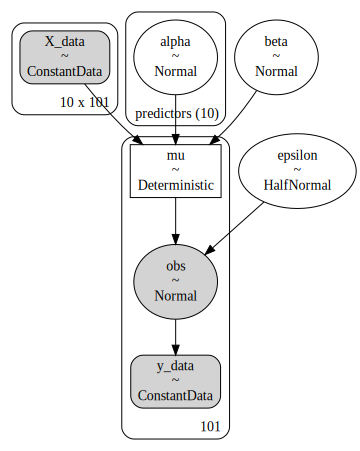

In [9]:
#　確率モデル定義
model1 = pm.Model(coords={"predictors": columns})

with model1:
    X_data = pm.ConstantData("X_data", X.T)
    y_data = pm.ConstantData("y_data", y)

    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0, dims="predictors")
    beta = pm.Normal("beta", mu=100.0, sigma=25.0) # 一次関数の切片にあたるため、scoreのスケールに沿った設定が必要になる
    epsilon = pm.HalfNormal("epsilon", sigma=25.0)

    mu = pm.Deterministic("mu", alpha @ X_data + beta)

    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model1)
display(g)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


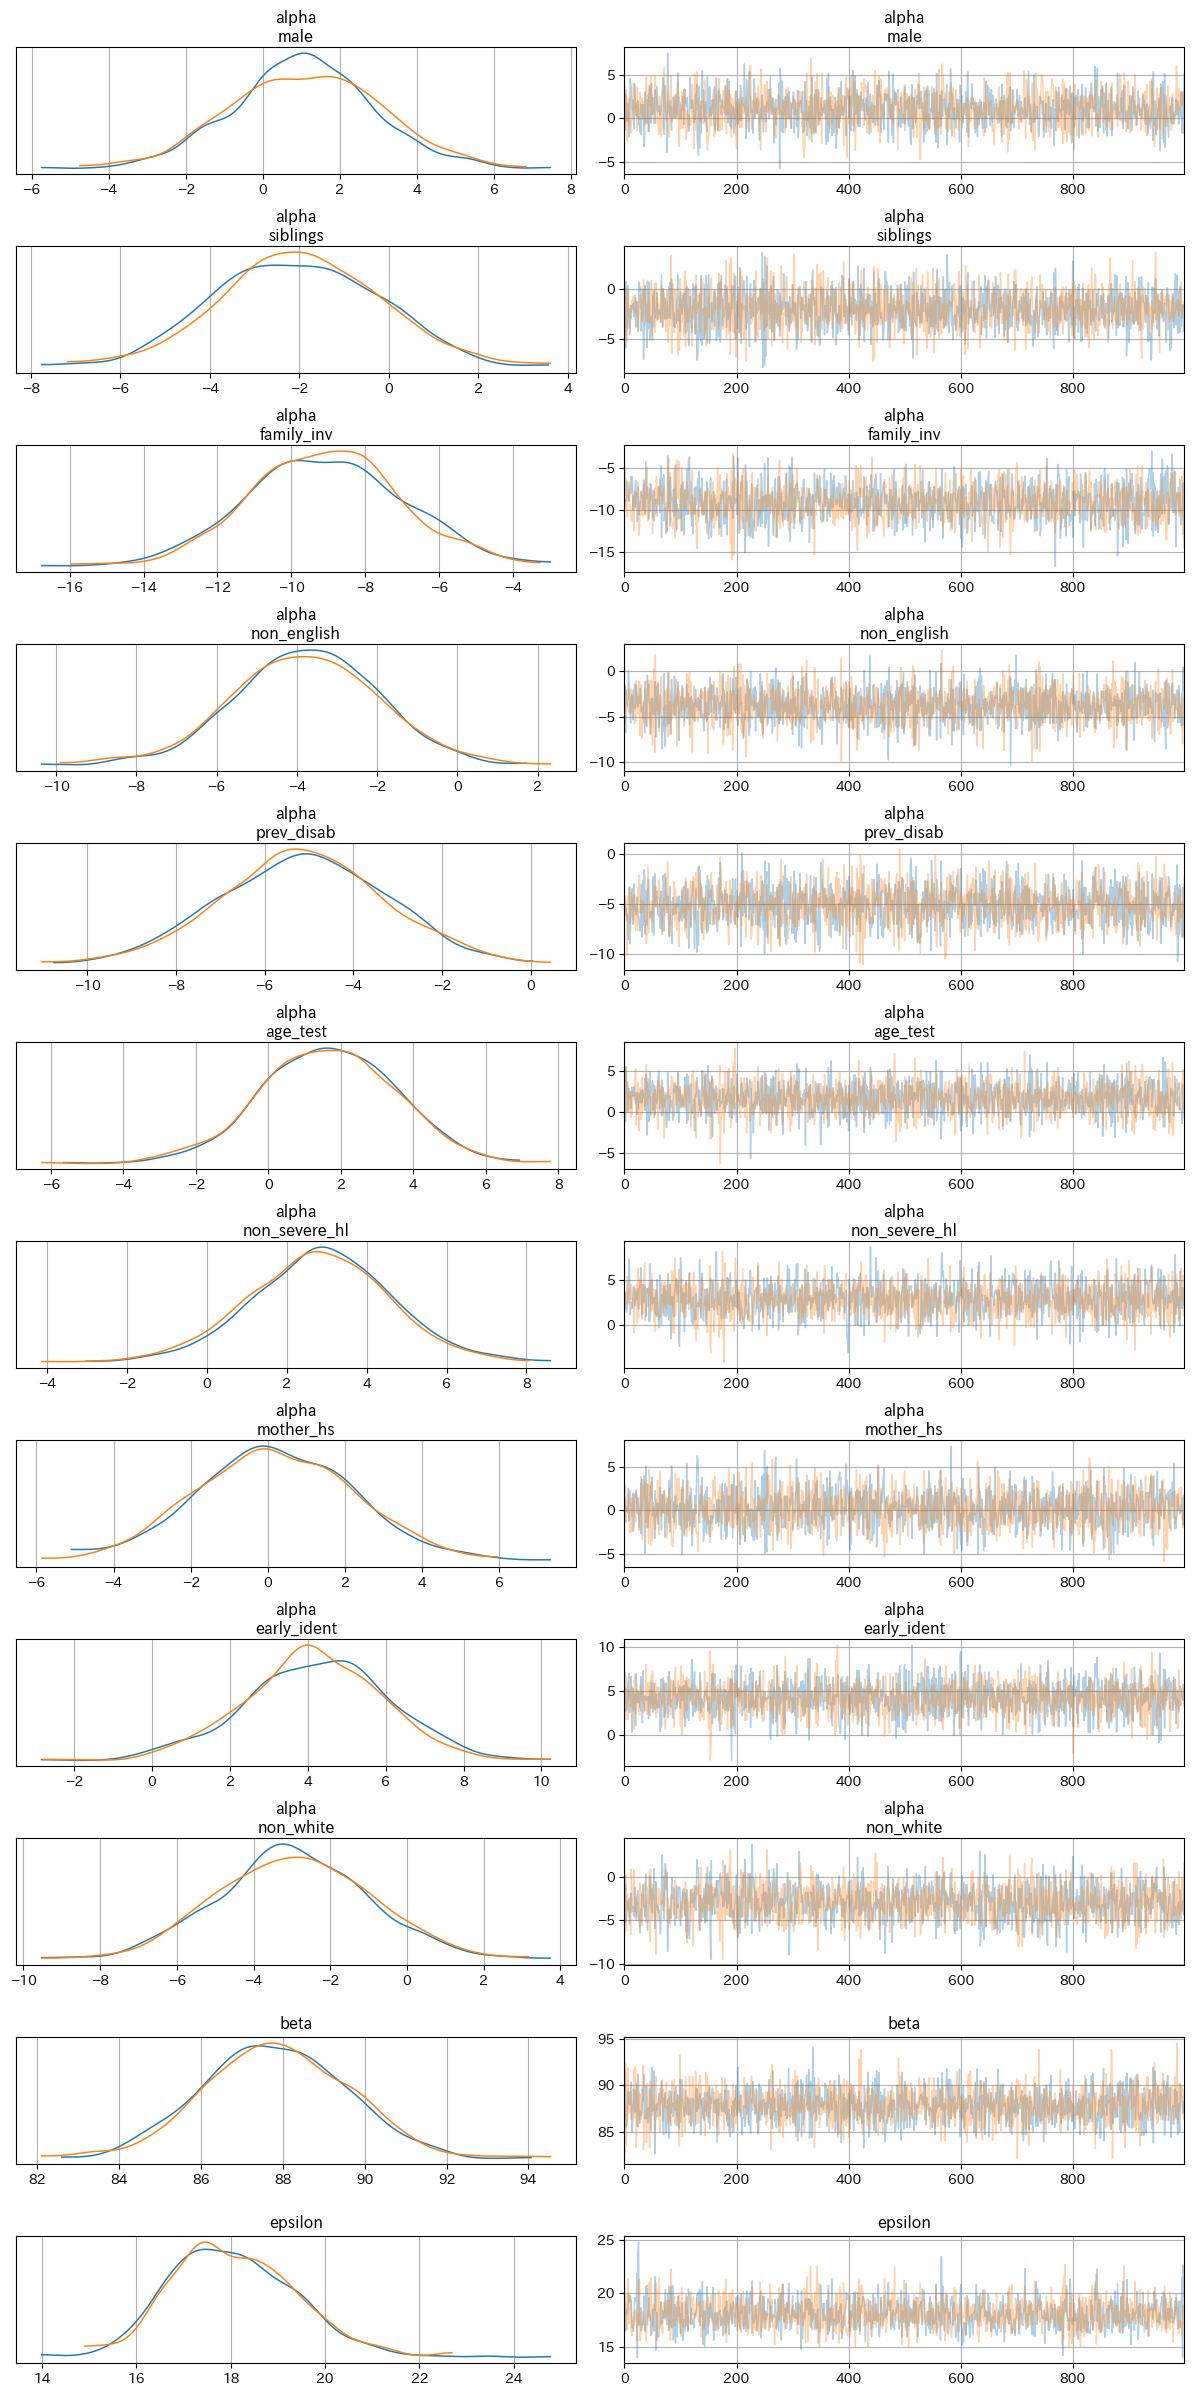

In [10]:
with model1:
    idata1 = pm.sample(random_seed=42, target_accept=0.95)

az.plot_trace(idata1, var_names=["alpha", "beta", "epsilon"], compact=False)
plt.tight_layout()
plt.show()

In [11]:
summary1 = az.summary(idata1)
display(summary1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],1.078,1.872,-2.242,4.842,0.042,0.037,1947.0,1560.0,1.0
alpha[siblings],-2.006,1.824,-5.313,1.421,0.037,0.033,2391.0,1528.0,1.0
alpha[family_inv],-9.079,2.080,-12.817,-5.078,0.049,0.035,1788.0,1258.0,1.0
alpha[non_english],-3.783,1.820,-7.064,-0.217,0.034,0.028,2848.0,1611.0,1.0
alpha[prev_disab],-5.136,1.851,-8.637,-1.725,0.041,0.030,1995.0,1488.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[96],83.002,5.390,73.354,93.619,0.111,0.079,2371.0,1340.0,1.0
mu[97],105.062,5.599,93.839,114.803,0.122,0.086,2103.0,1446.0,1.0
mu[98],75.199,6.541,63.232,87.274,0.133,0.094,2398.0,1708.0,1.0
mu[99],83.740,5.485,74.007,94.245,0.123,0.087,1981.0,1361.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

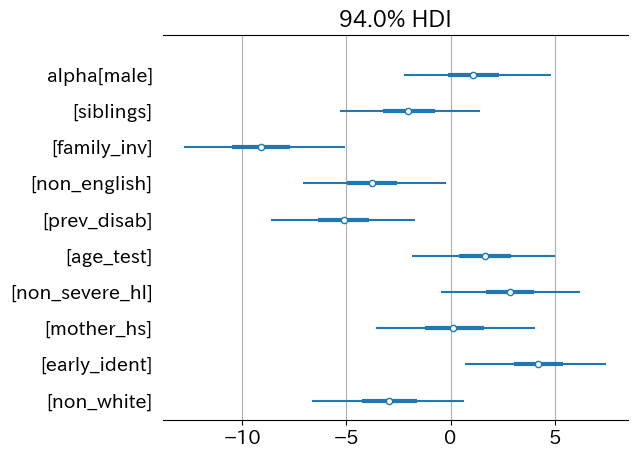

In [12]:
az.plot_forest(idata1, combined=True, var_names=["alpha"])

- 性別 male or not が正の相関を持つとは断言難しい
- siblings, age_test, non_severe_hlm mother_hs, early_ident などは正の相関があると言えそう
- maleはサンプルのうちおよそ25%が負の相関を見出していて、判断軸として適切ではない

## 少し複雑なモデルで回帰分析
チュートリアルで採用してるモデルで実施してみる


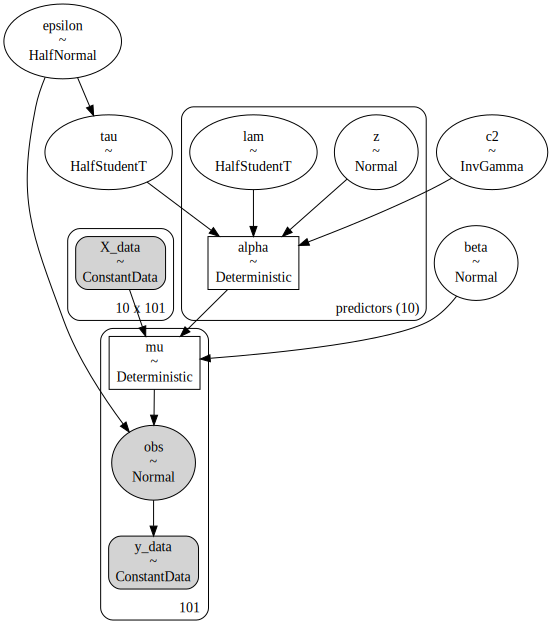

In [15]:
D0 = int(D / 2)

model2 = pm.Model(coords={"predictors": columns})

with model2:
    X_data = pm.ConstantData("X_data", X.T)
    y_data = pm.ConstantData("y_data", y)

    epsilon = pm.HalfNormal("epsilon", sigma=25)

    tau = pm.HalfStudentT("tau", 2, D0 / (D-D0) * epsilon / np.sqrt(N))

    lam = pm.HalfStudentT("lam", nu=2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")

    alpha = pm.Deterministic(
        "alpha", z * tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2)),
        dims="predictors"
    )

    beta = pm.Normal("beta", mu=100, sigma=25)

    mu = pm.Deterministic("mu", alpha @ X_data + beta)

    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model2)
display(g)

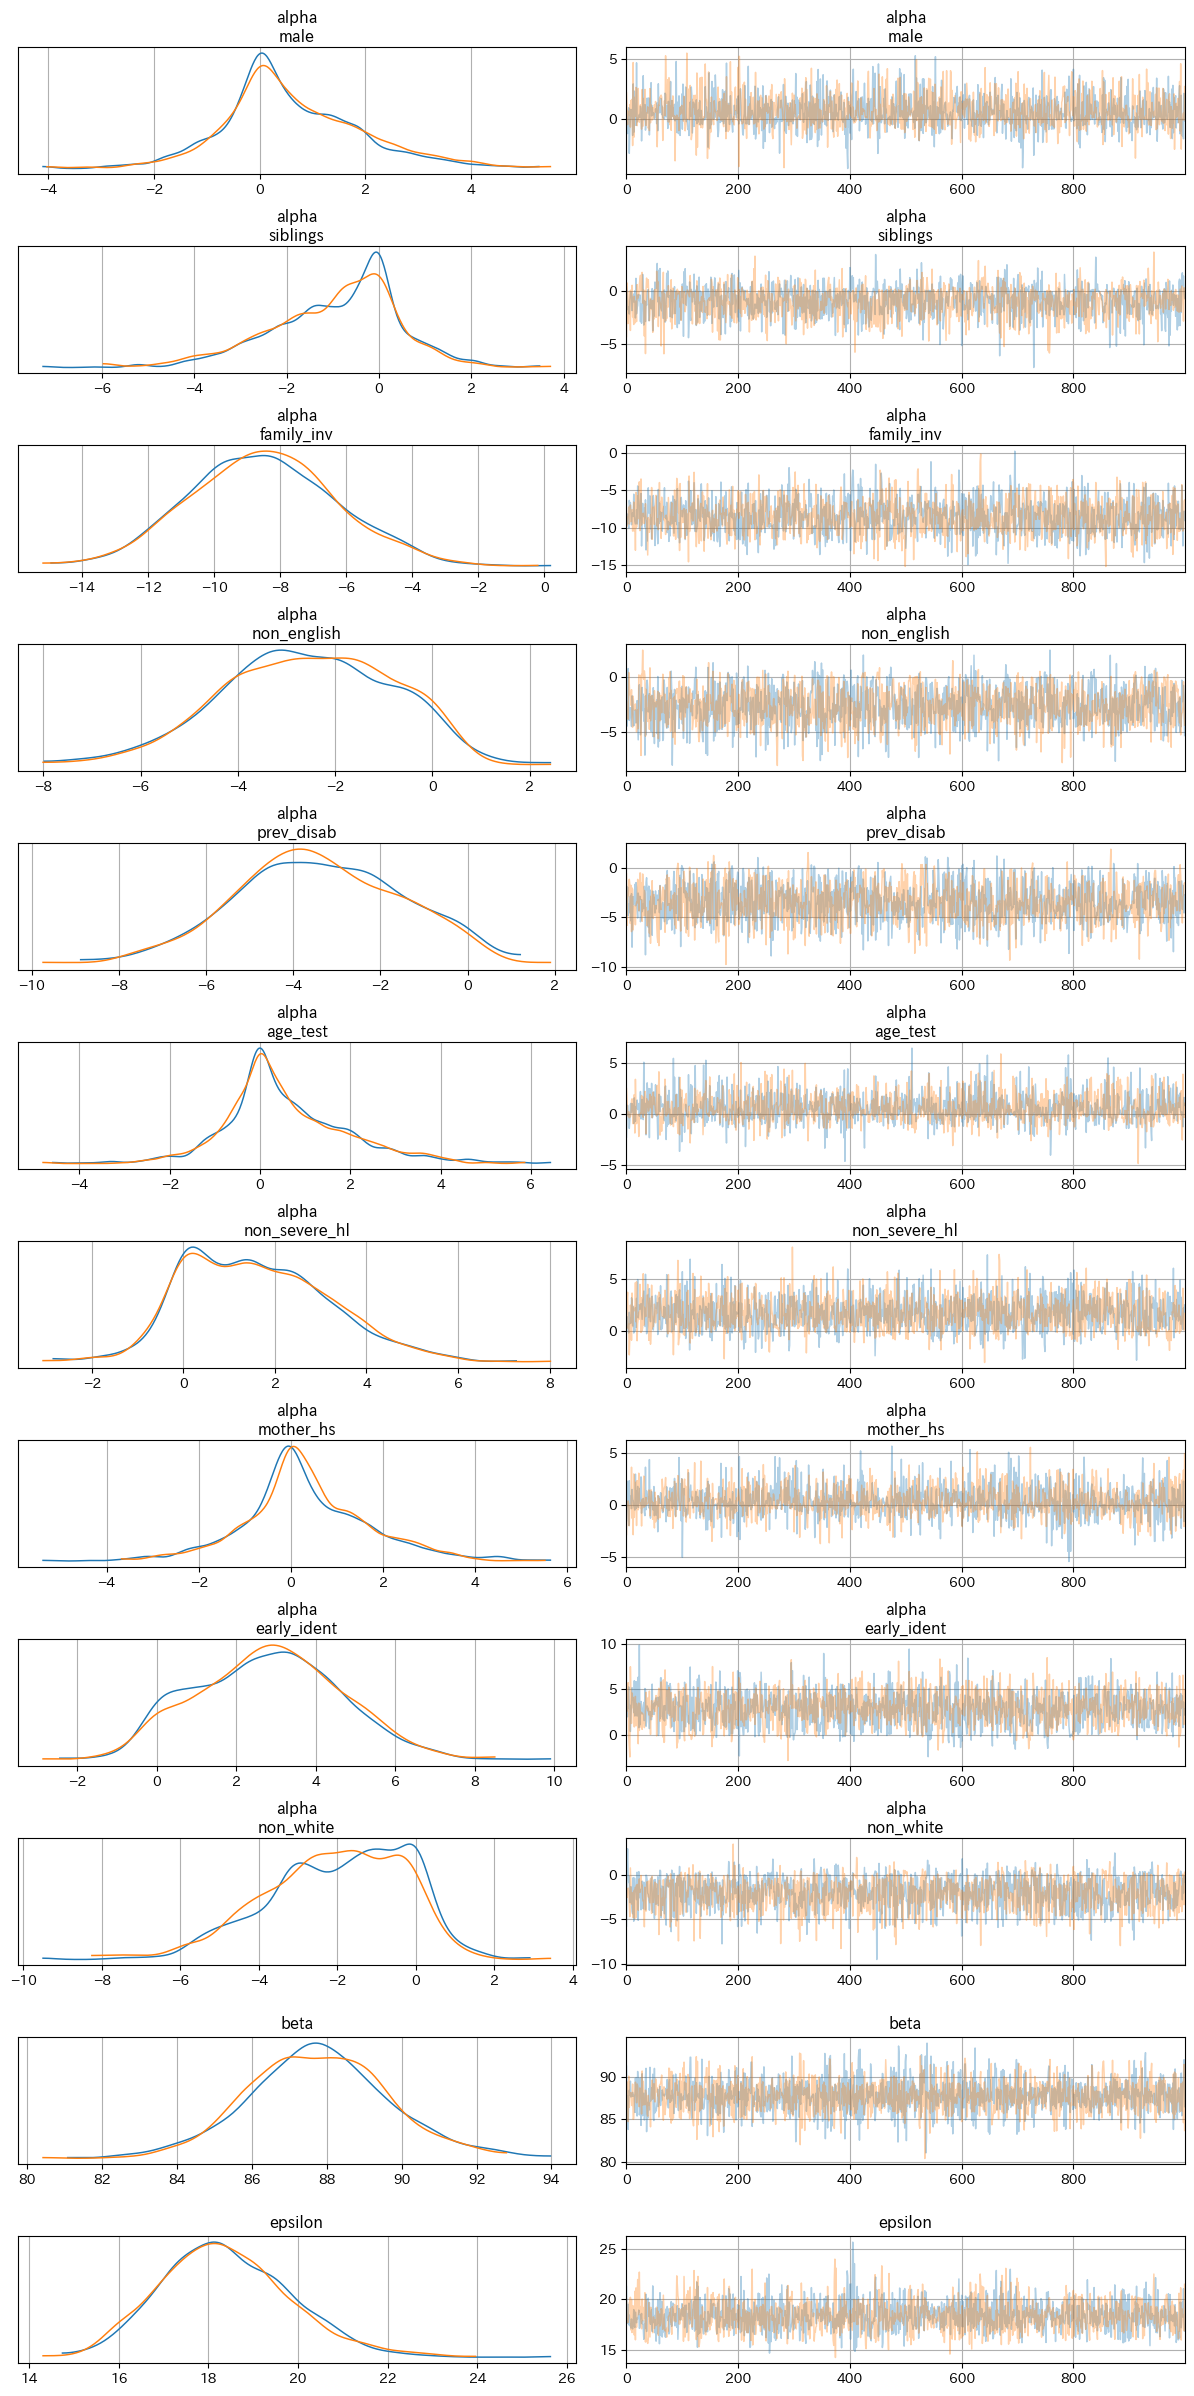

In [16]:
with model2:
    idata2 = pm.sample(random_seed=42, target_accept=0.95)

az.plot_trace(idata2, var_names=["alpha", "beta", "epsilon"], compact=False)
plt.tight_layout()
plt.show()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

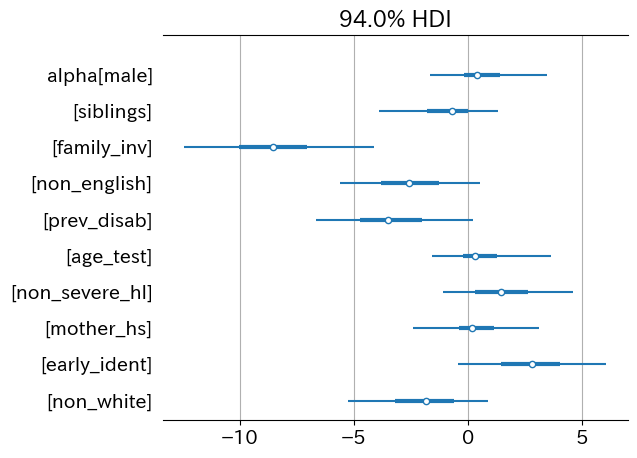

In [17]:
az.plot_forest(idata2, combined=True, var_names=["alpha"])

このフォレスト図を見ると、先のシンプルな線形回帰の場合と全体的な傾向は一致している。

結論：**説明変数ごとの大まかな寄与度合いを調べるだけなら、シンプルな線形回帰モデルでも対応可能**